<a href="https://colab.research.google.com/github/berberberk/timl-fs-2024/blob/main/TIML_4_5_Classifiers%2BTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image.png](https://miro.medium.com/v2/resize:fit:607/1*suPyzoInkRqOJivGlfsXPA.png)

# Импорт библиотек


In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00


In [16]:

import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, auc, precision_score, recall_score, classification_report

from sklearn.decomposition import PCA


# Загрузка датасета

In [5]:
path = kagglehub.dataset_download("muratkokludataset/raisin-dataset", path='Raisin_Dataset/Raisin_Dataset.xlsx')

print("Path to dataset files:", path)

100%|██████████| 82.6k/82.6k [00:00<00:00, 30.2MB/s]

Path to dataset files: /root/.cache/kagglehub/datasets/muratkokludataset/raisin-dataset/versions/1/Raisin_Dataset/Raisin_Dataset.xlsx


**Описания столбцов**
* Area: Количество пикселей в пределах границы изюминки.
* MajorAxisLength: Длина самой длинной оси, которую можно нарисовать на изюминке.
* MinorAxisLength: длина кратчайшей оси, которую можно нарисовать на изюминке.
* Eccentricity: мера длины изюминки по сравнению с идеальной окружностью.
* ConvexArea: количество пикселей в наименьшей выпуклой области, окружающей изюминку.
* Extent: отношение площади области, образованной изюминкой, к общему количеству пикселей в ограничивающей рамке.
* Perimeter: расстояние вокруг границы изюминки.
* Class: Классификационный знак, указывающий, относится ли изюм к сорту Кечимен или Бесни.

**Краткое описание набора данных**
* Общее количество образцов: 900
* Количество признаков: 7
* Сорта: Кечимен, Бесни.
* Источник: Classification of Raisin Grains Using Machine Vision and Artificial Intelligence Methods, Gazi Journal of Engineering Sciences, December 2020.

In [6]:
df = pd.read_excel(path)
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [7]:
# Проверка на пропущенные значения
print("\nПроверка пропущенных значений:")
print(df.isnull().sum())



Проверка пропущенных значений:
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
Extent             0
Perimeter          0
Class              0
dtype: int64


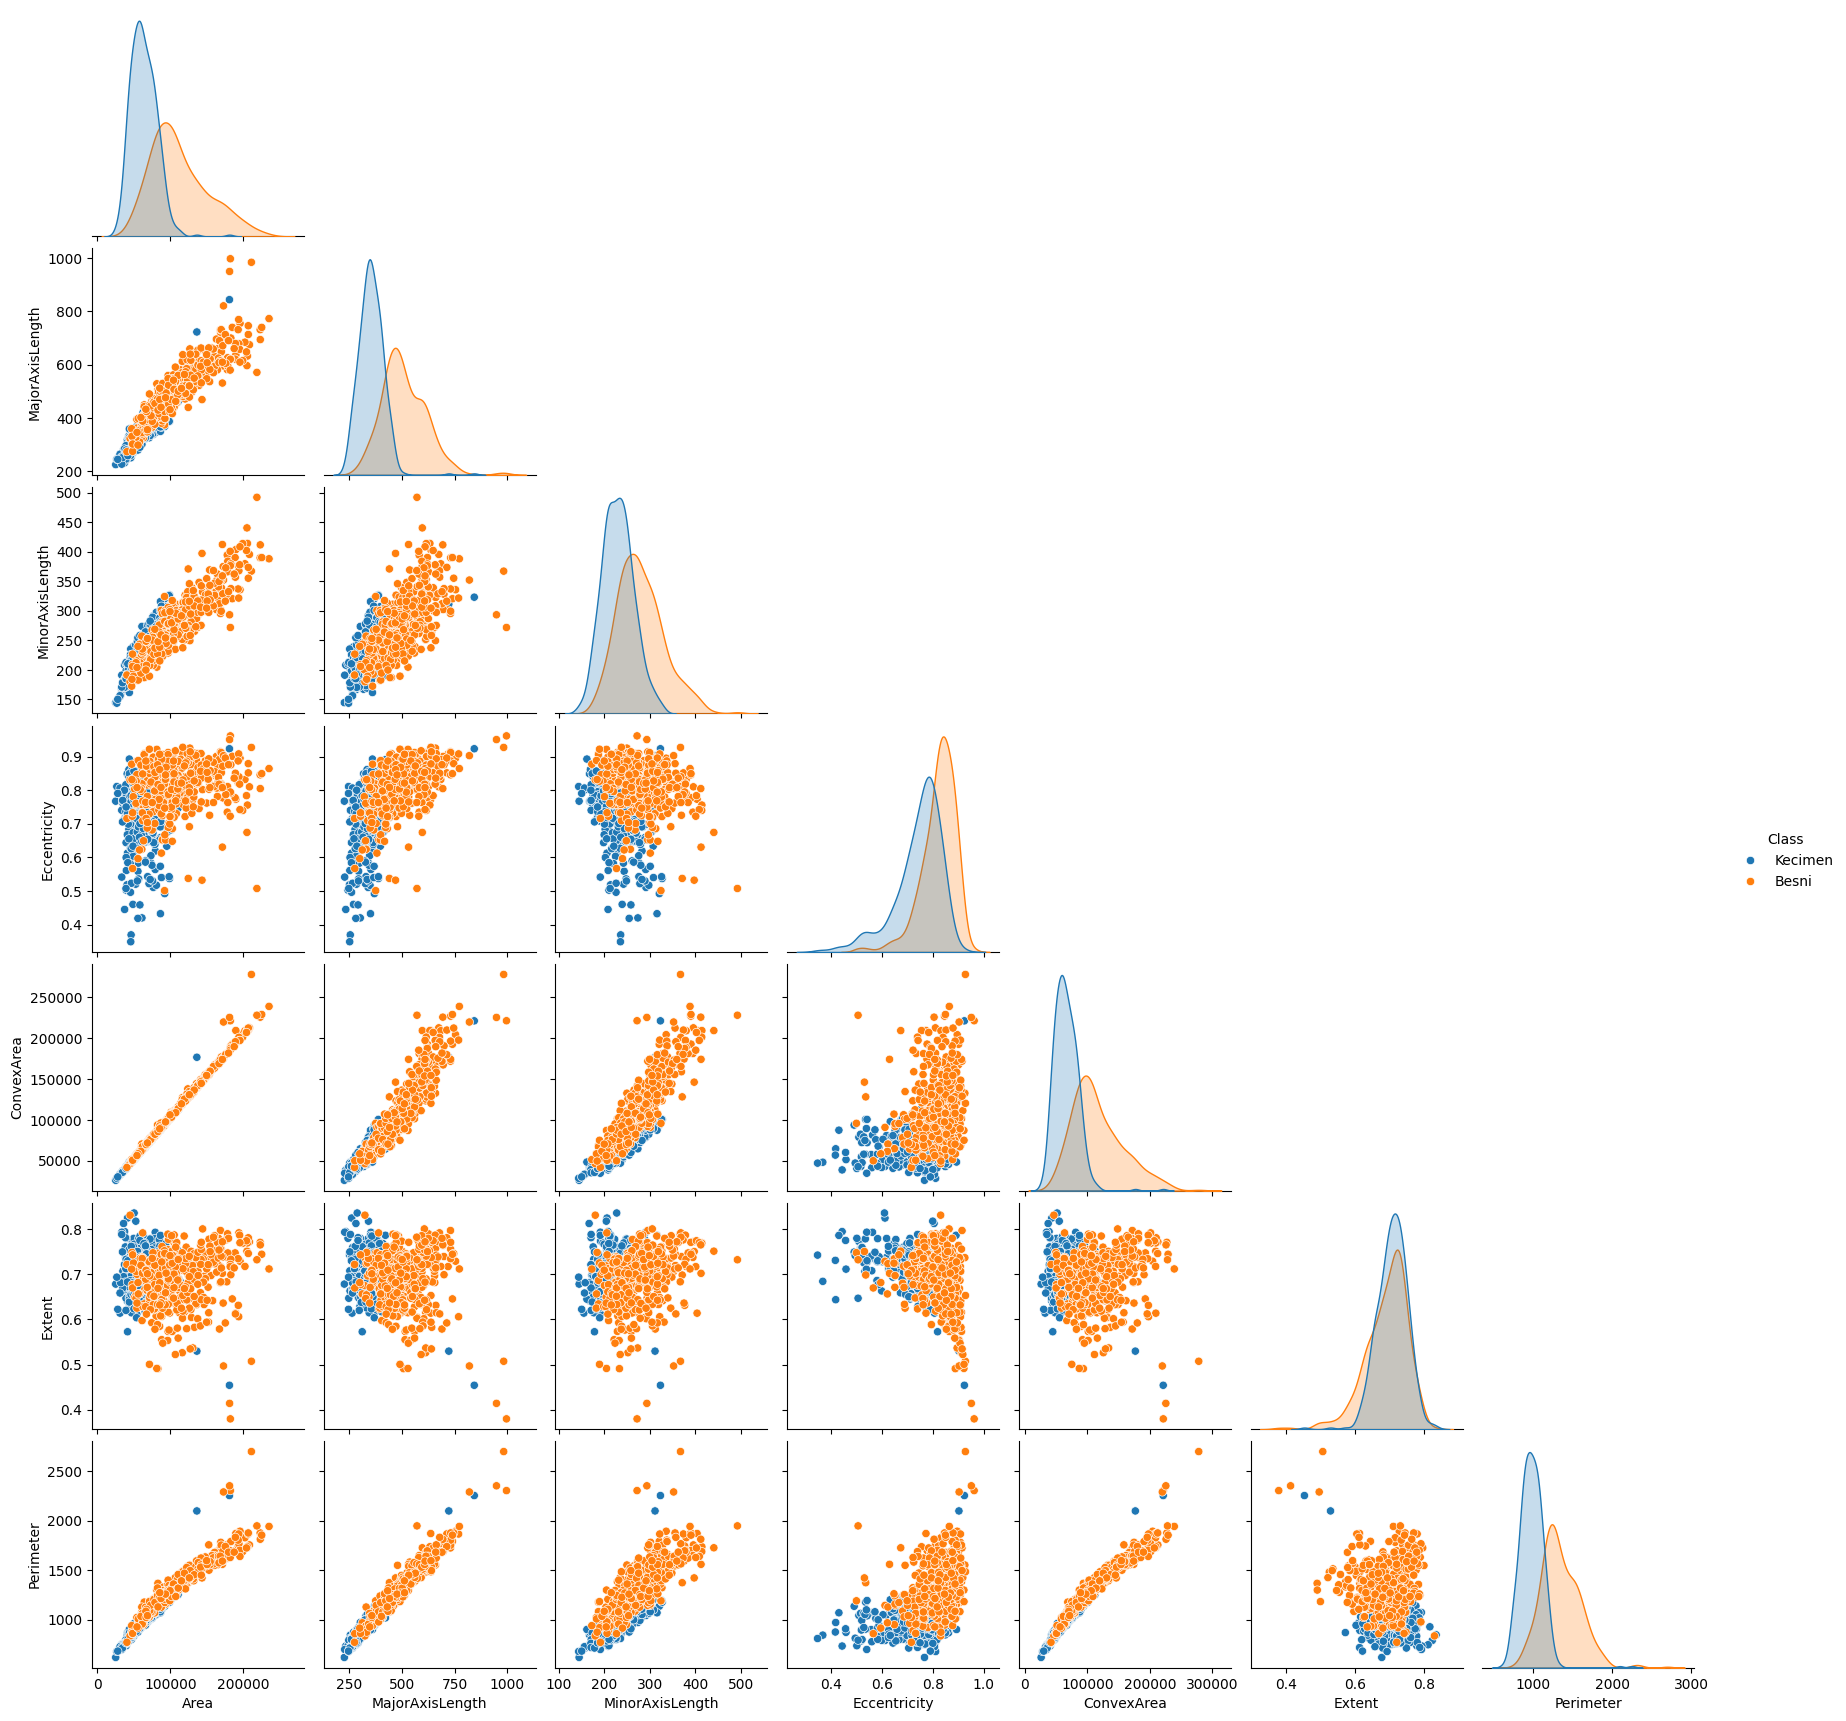

In [8]:
sns.pairplot(df, hue='Class', corner=True, diag_kind='kde')

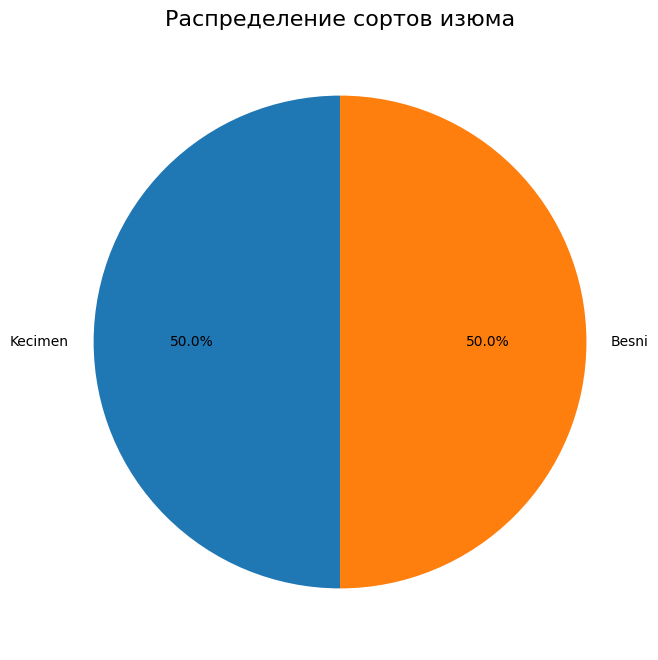

In [9]:
plt.figure(figsize=(12, 8))
class_counts = df['Class'].value_counts()
plt.pie(class_counts,
        labels=class_counts.index,
        autopct='%1.1f%%',
        startangle=90)
plt.title('Распределение сортов изюма', fontsize=16)
plt.show()

# Подготовка данных

In [10]:

X = df.drop('Class', axis=1)
y = df['Class']
X.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251


In [11]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Сначала сплит

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nРазмеры выборок:")
print(f"Обучающая выборка: {X_train_scaled.shape}, Тестовая выборка: {X_test_scaled.shape}")


Размеры выборок:
Обучающая выборка: (630, 7), Тестовая выборка: (270, 7)


# Реализация моделей классификации

In [13]:

# Логистическая регрессия
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
y_proba_log = log_reg.predict_proba(X_test_scaled)

print(y_pred_log[:10], y_proba_log[:10])

# K-ближайшие соседи
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
y_proba_knn = knn.predict_proba(X_test_scaled)

print(y_pred_knn[:10], y_proba_knn[:10])

# Метод опорных векторов
svc = SVC(probability=True)
svc.fit(X_train_scaled, y_train)
y_pred_svc = svc.predict(X_test_scaled)
y_proba_svc = svc.predict_proba(X_test_scaled)

print(y_pred_svc[:10], y_proba_svc[:10])

[0 1 0 1 1 0 1 1 1 1] [[7.69185022e-01 2.30814978e-01]
 [3.90948735e-02 9.60905127e-01]
 [9.99770591e-01 2.29409020e-04]
 [1.14078223e-02 9.88592178e-01]
 [1.02135263e-01 8.97864737e-01]
 [9.14166185e-01 8.58338146e-02]
 [3.52283673e-01 6.47716327e-01]
 [2.32904090e-01 7.67095910e-01]
 [5.13503878e-02 9.48649612e-01]
 [3.03783826e-02 9.69621617e-01]]
[0 1 0 1 1 0 1 1 1 1] [[0.8 0.2]
 [0.2 0.8]
 [1.  0. ]
 [0.2 0.8]
 [0.  1. ]
 [1.  0. ]
 [0.2 0.8]
 [0.4 0.6]
 [0.  1. ]
 [0.  1. ]]
[0 1 0 1 1 0 1 1 1 1] [[0.90232803 0.09767197]
 [0.10767174 0.89232826]
 [0.92566545 0.07433455]
 [0.15040031 0.84959969]
 [0.05957983 0.94042017]
 [0.98726477 0.01273523]
 [0.23553761 0.76446239]
 [0.1883515  0.8116485 ]
 [0.06615001 0.93384999]
 [0.07738953 0.92261047]]


# Реализация деревянных моделей

In [14]:

# Инициализация и обучение дерева решений
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

# Предсказание и оценка
y_pred_tree = tree_clf.predict(X_test)
y_proba_tree = tree_clf.predict_proba(X_test)

print("\nРезультаты модели 'Дерево решений':")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("F1-Score:", f1_score(y_test, y_pred_tree))
print("Classification Report:\n", classification_report(y_test, y_pred_tree))



Результаты модели 'Дерево решений':
Accuracy: 0.825925925925926
F1-Score: 0.833922261484099
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82       135
           1       0.80      0.87      0.83       135

    accuracy                           0.83       270
   macro avg       0.83      0.83      0.83       270
weighted avg       0.83      0.83      0.83       270



In [17]:
# Определение гиперпараметров для подбора
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшая модель
best_tree_clf = grid_search.best_estimator_
print("\nЛучшие параметры для дерева решений:", grid_search.best_params_)

# Предсказание с лучшей моделью
y_pred_best_tree = best_tree_clf.predict(X_test)
y_proba_best_tree = best_tree_clf.predict_proba(X_test)
print("Accuracy (GridSearch):", accuracy_score(y_test, y_pred_best_tree))
print("F1-Score (GridSearch):", f1_score(y_test, y_pred_best_tree))



Лучшие параметры для дерева решений: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy (GridSearch): 0.8333333333333334
F1-Score (GridSearch): 0.8387096774193549


Лучшее дерево на основе GridSearch:


[Text(0.5, 0.875, 'x[6] <= 1157.045\ngini = 0.5\nsamples = 630\nvalue = [315, 315]'),
 Text(0.25, 0.625, 'x[6] <= 1124.152\ngini = 0.256\nsamples = 338\nvalue = [51, 287]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[3] <= 0.868\ngini = 0.21\nsamples = 310\nvalue = [37, 273]'),
 Text(0.0625, 0.125, 'gini = 0.189\nsamples = 303\nvalue = [32, 271]'),
 Text(0.1875, 0.125, 'gini = 0.408\nsamples = 7\nvalue = [5, 2]'),
 Text(0.375, 0.375, 'x[6] <= 1144.966\ngini = 0.5\nsamples = 28\nvalue = [14, 14]'),
 Text(0.3125, 0.125, 'gini = 0.455\nsamples = 20\nvalue = [13, 7]'),
 Text(0.4375, 0.125, 'gini = 0.219\nsamples = 8\nvalue = [1, 7]'),
 Text(0.75, 0.625, 'x[1] <= 461.595\ngini = 0.173\nsamples = 292\nvalue = [264, 28]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[5] <= 0.752\ngini = 0.439\nsamples = 77\nvalue = [52, 25]'),
 Text(0.5625, 0.125, 'gini = 0.399\nsamples = 69\nvalue = [50, 19]'),
 Text(0.6875, 0.125, 'gini = 0.375\nsamples = 8\nvalue = [2, 6]'),
 Text(0.875,

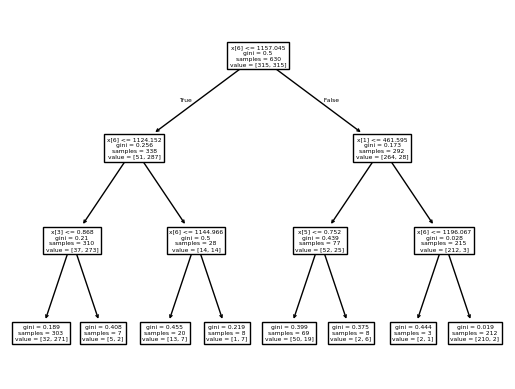

In [19]:
print("Лучшее дерево на основе GridSearch:")
plot_tree(best_tree_clf)


In [20]:
# Бэггинг с базовым классификатором - деревом решений
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_clf.fit(X_train, y_train)

y_pred_bagging = bagging_clf.predict(X_test)
y_proba_bagging = bagging_clf.predict_proba(X_test)
print("\nРезультаты модели 'Бэггинг':")
print("Accuracy:", accuracy_score(y_test, y_pred_bagging))
print("F1-Score:", f1_score(y_test, y_pred_bagging))



Результаты модели 'Бэггинг':
Accuracy: 0.837037037037037
F1-Score: 0.8472222222222222


In [21]:
# Случайный лес
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict(X_test)
print("\nРезультаты модели 'Случайный лес':")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf))



Результаты модели 'Случайный лес':
Accuracy: 0.837037037037037
F1-Score: 0.8461538461538461


In [22]:
# XGBoost
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)
print("\nРезультаты модели 'XGBoost':")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1-Score:", f1_score(y_test, y_pred_xgb))

# CatBoost
cat_clf = CatBoostClassifier(verbose=0, random_state=42)
cat_clf.fit(X_train, y_train)

y_pred_cat = cat_clf.predict(X_test)
y_proba_cat = cat_clf.predict_proba(X_test)
print("\nРезультаты модели 'CatBoost':")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print("F1-Score:", f1_score(y_test, y_pred_cat))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:03:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Результаты модели 'XGBoost':
Accuracy: 0.8333333333333334
F1-Score: 0.8442906574394463

Результаты модели 'CatBoost':
Accuracy: 0.837037037037037
F1-Score: 0.8461538461538461


In [23]:
from sklearn.ensemble import StackingClassifier

# Определение базовых моделей для стекинга
estimators = [
    ('gboost', GradientBoostingClassifier(random_state=42)),
    ('bagging', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42))
]

# Модель стекинга с логистической регрессией на выходе
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stack_clf.fit(X_train, y_train)

y_pred_stack = stack_clf.predict(X_test)
y_proba_stack = stack_clf.predict_proba(X_test)
print("\nРезультаты модели 'Стекинг':")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("F1-Score:", f1_score(y_test, y_pred_stack))



Результаты модели 'Стекинг':
Accuracy: 0.8407407407407408
F1-Score: 0.8491228070175438


# Оценка моделей

In [24]:
def plot_confusion_matrix(y_test, y_pred, title="Матрица ошибок"):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Kecimen", "Besni"], yticklabels=["Kecimen", "Besni"])
    plt.title(title)
    plt.xlabel("Прогноз")
    plt.ylabel("Реальность")
    plt.show()

In [39]:
def plot_predicted_classes(X_test_scaled, y_test, y_pred, title="Результаты классификации"):
    pca = PCA(n_components=2, random_state=42)
    data_pca = pca.fit_transform(X_test_scaled)
    pd.DataFrame(data_pca).head()
    plt.figure(figsize=(8, 6))
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=(y_pred[:]))
    plt.title(title)
    plt.xlabel('Первая главная компонента')
    plt.ylabel('Вторая главная компонента')
    plt.show()


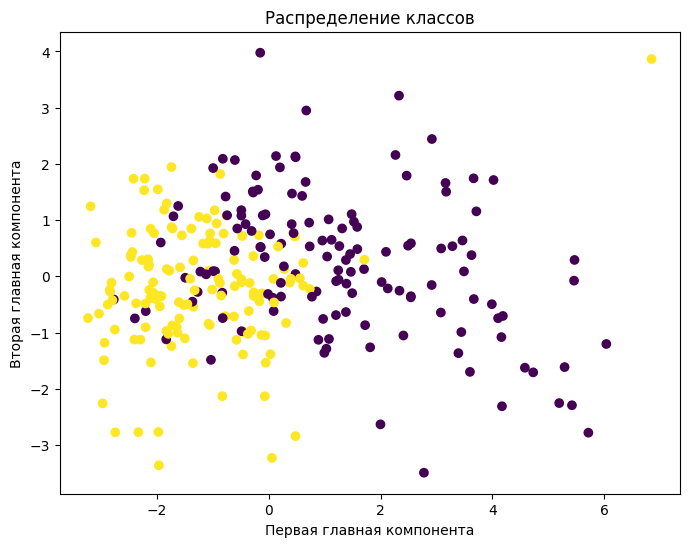

In [40]:
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(X_test_scaled)
pd.DataFrame(data_pca).head()

plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=y_test)
plt.title('Распределение классов')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.show()


Оценка моделей:


Логистическая регрессия:
Accuracy: 0.859
F1-Score: 0.859
ROC-AUC: 0.859


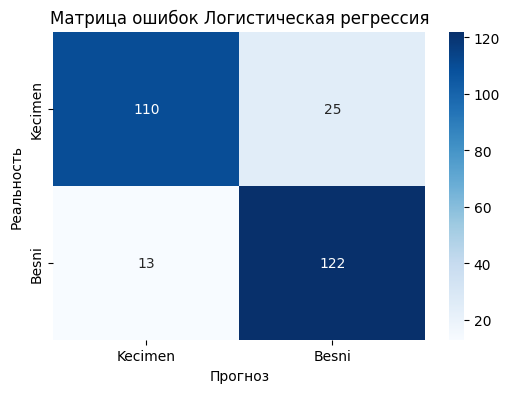

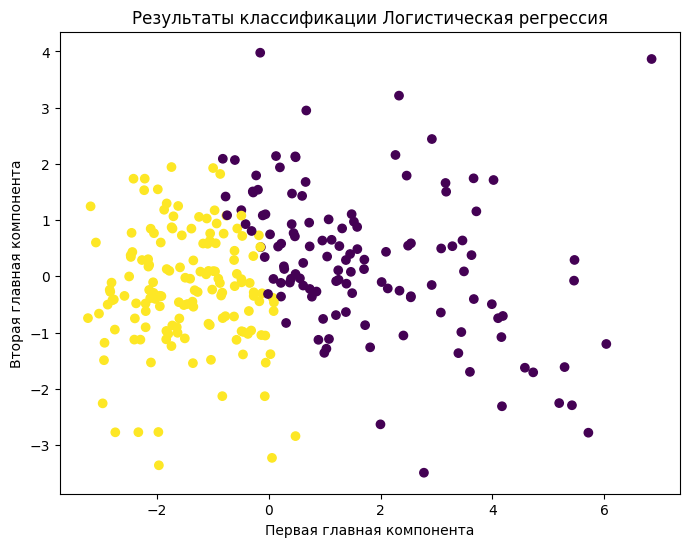



Метод K-ближайших соседей:
Accuracy: 0.826
F1-Score: 0.825
ROC-AUC: 0.826


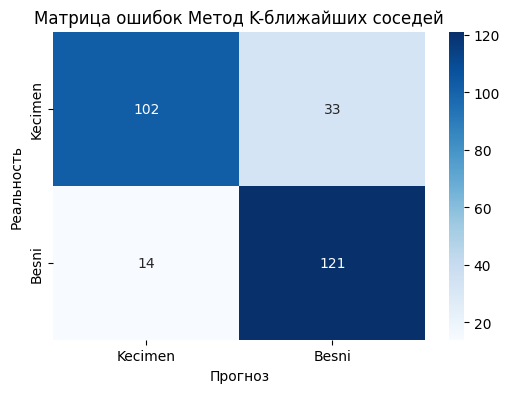

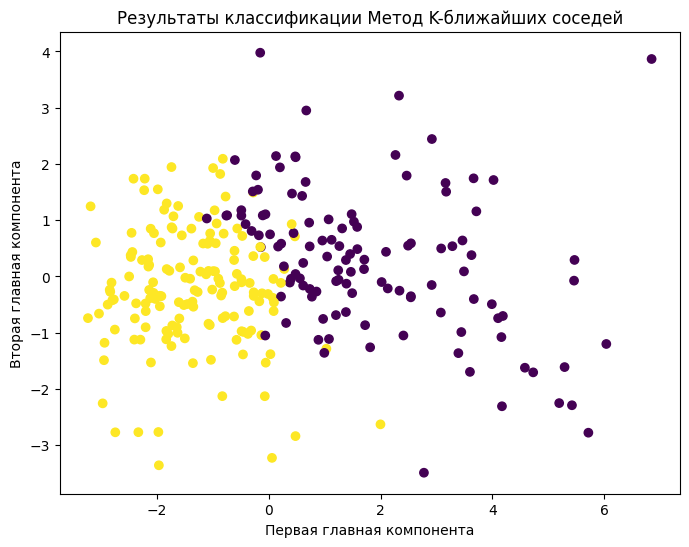



Метод опорных векторов:
Accuracy: 0.848
F1-Score: 0.847
ROC-AUC: 0.848


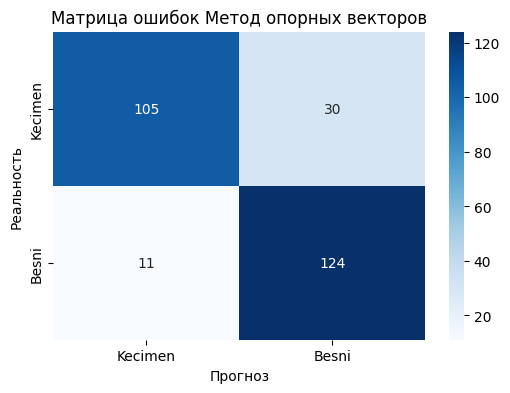

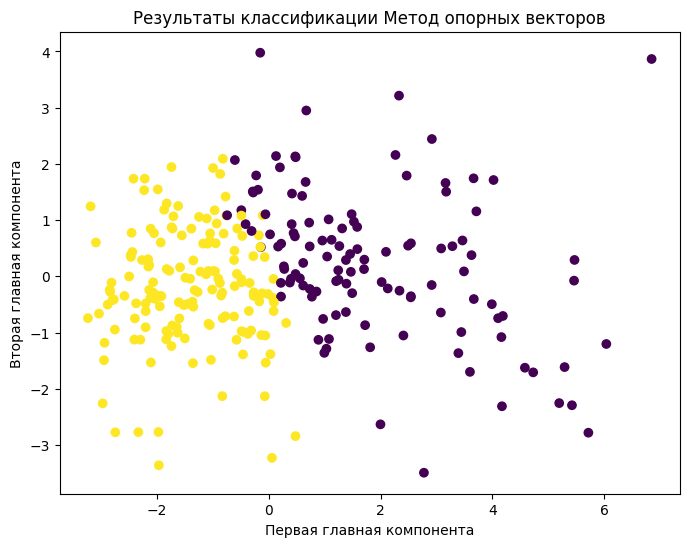



Дерево решений:
Accuracy: 0.826
F1-Score: 0.826
ROC-AUC: 0.826


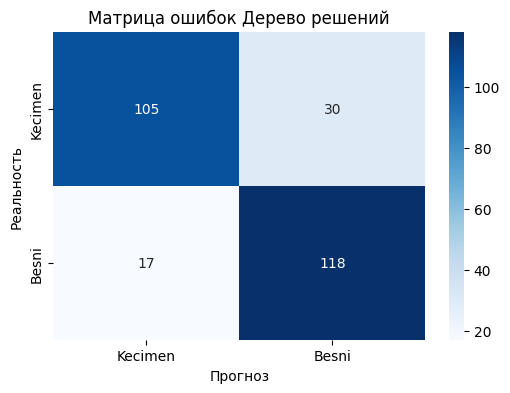

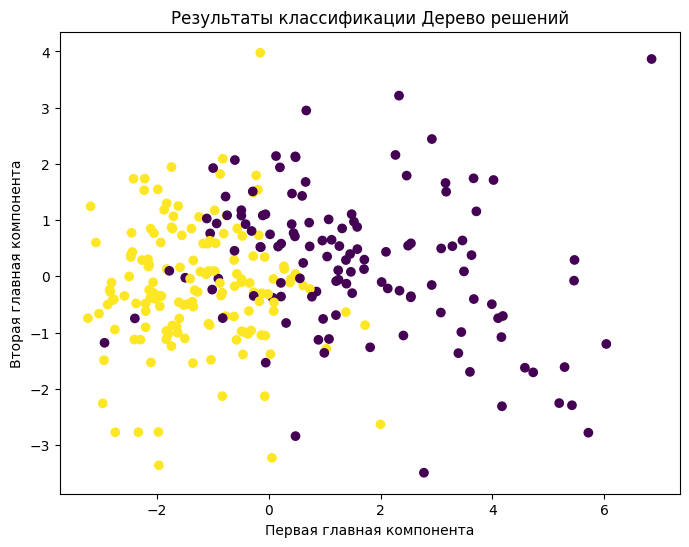



Дерево решений с оптимальными гиперпараметрами:
Accuracy: 0.833
F1-Score: 0.833
ROC-AUC: 0.833


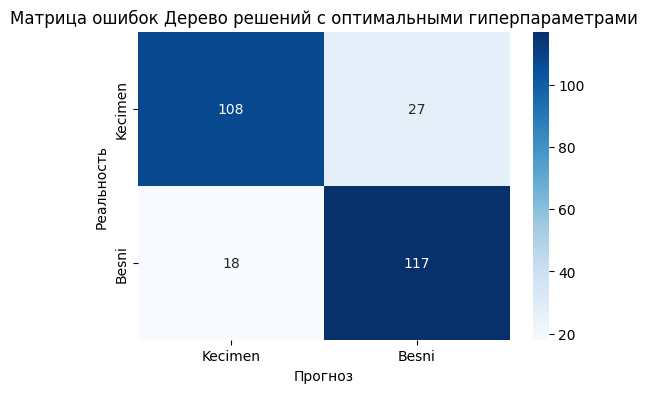

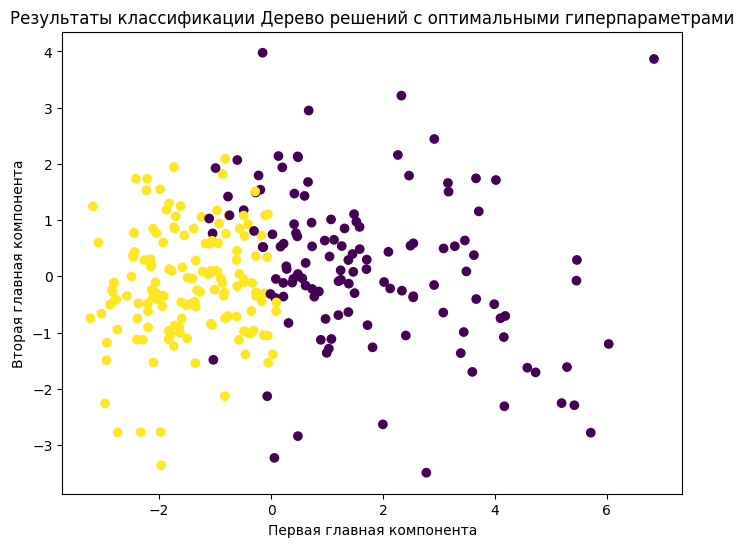



Случайный лес:
Accuracy: 0.837
F1-Score: 0.836
ROC-AUC: 0.837


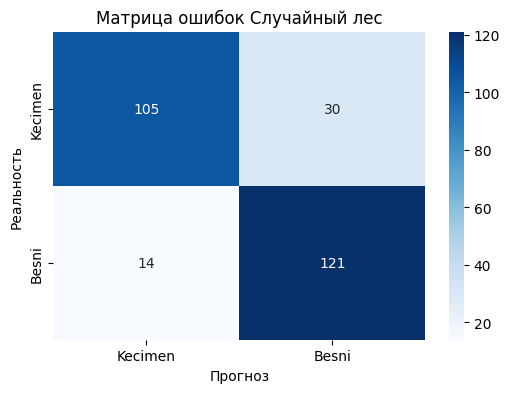

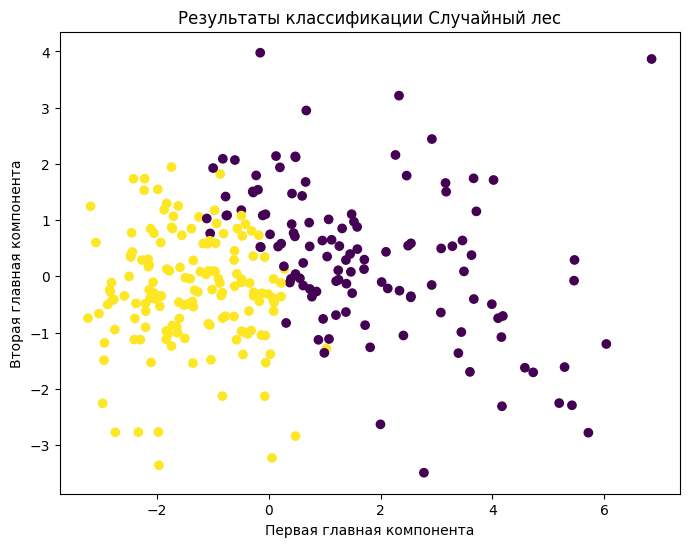



Бэггинг:
Accuracy: 0.837
F1-Score: 0.836
ROC-AUC: 0.837


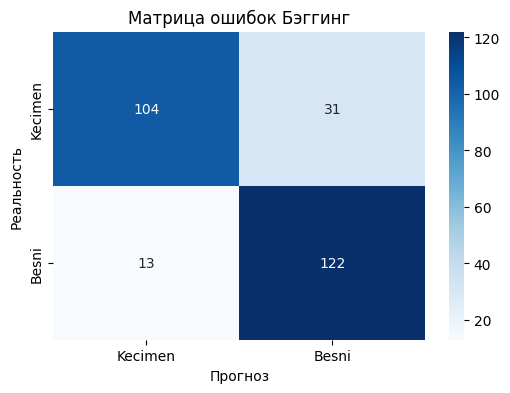

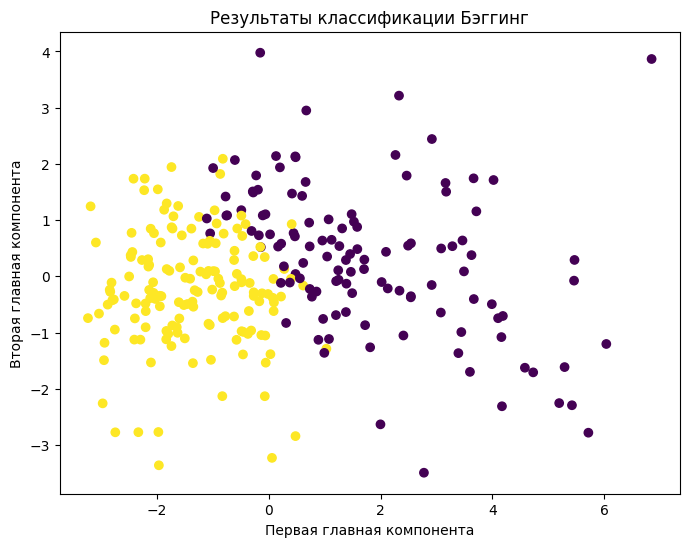



XGBoost:
Accuracy: 0.833
F1-Score: 0.833
ROC-AUC: 0.833


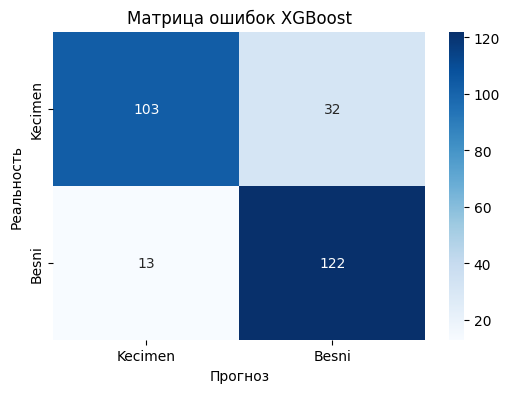

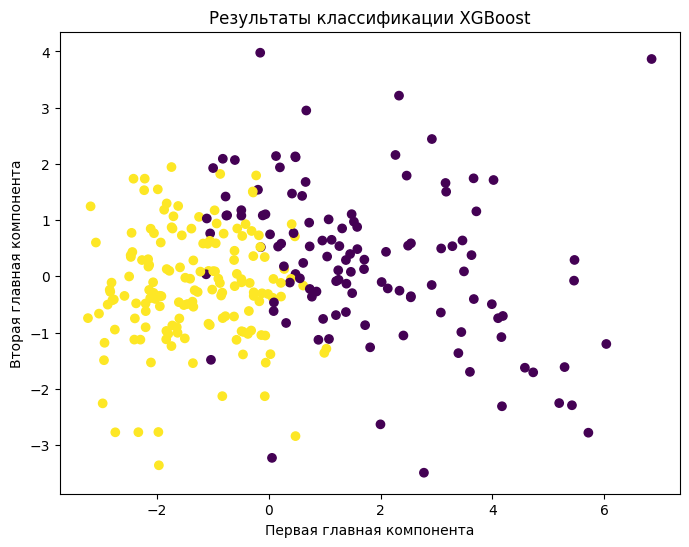



CatBoost:
Accuracy: 0.837
F1-Score: 0.836
ROC-AUC: 0.837


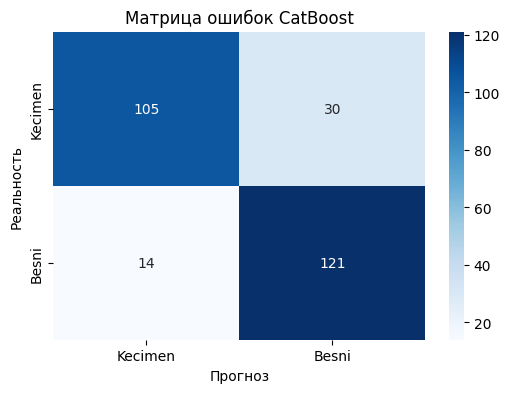

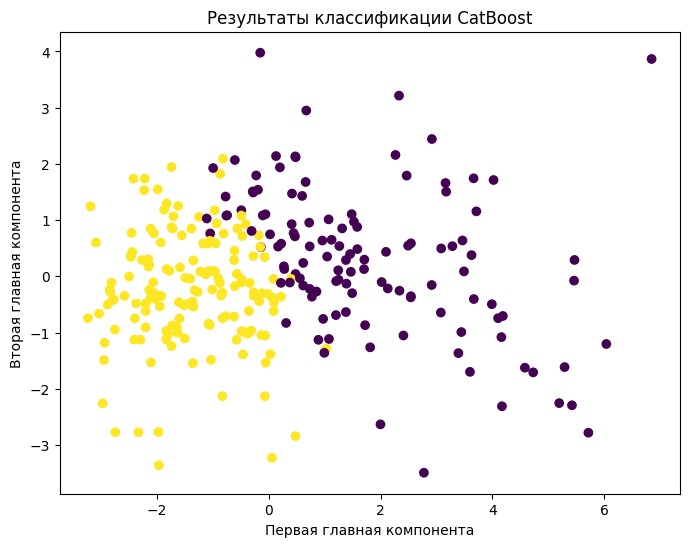



Стэкинг (Бустинг + Бэггинг):
Accuracy: 0.841
F1-Score: 0.840
ROC-AUC: 0.841


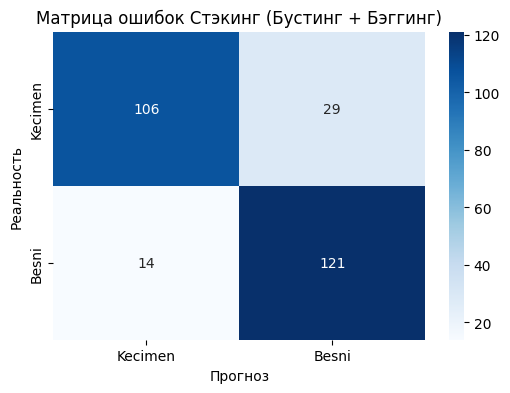

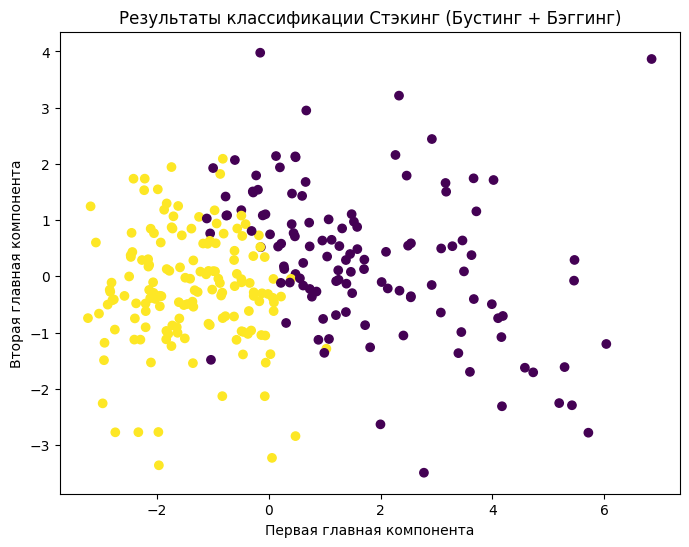

In [42]:
def evaluate_model(name, X_test, y_test, y_pred, y_proba):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"\n\n{name}:")
    print(f"Accuracy: {acc:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"ROC-AUC: {roc_auc:.3f}")
    plot_confusion_matrix(y_test, y_pred, title=f"Матрица ошибок {name}")
    plot_predicted_classes(X_test, y_test, y_pred, title=f"Результаты классификации {name}")

print("\nОценка моделей:")
evaluate_model("Логистическая регрессия", X_test_scaled, y_test, y_pred_log, y_proba_log)
evaluate_model("Метод K-ближайших соседей", X_test_scaled, y_test, y_pred_knn, y_proba_knn)
evaluate_model("Метод опорных векторов", X_test_scaled, y_test, y_pred_svc, y_proba_svc)
evaluate_model("Дерево решений", X_test_scaled, y_test, y_pred_tree, y_proba_tree)
evaluate_model("Дерево решений с оптимальными гиперпараметрами", X_test_scaled, y_test, y_pred_best_tree, y_proba_best_tree)
evaluate_model("Бэггинг", X_test_scaled, y_test, y_pred_bagging, y_proba_bagging)
evaluate_model("Случайный лес", X_test_scaled, y_test, y_pred_rf, y_proba_rf)
evaluate_model("XGBoost", X_test_scaled, y_test, y_pred_xgb, y_proba_xgb)
evaluate_model("CatBoost", X_test_scaled, y_test, y_pred_cat, y_proba_cat)
evaluate_model("Стэкинг (Бустинг + Бэггинг)", X_test_scaled, y_test, y_pred_stack, y_proba_stack)

# PR и ROC-кривые

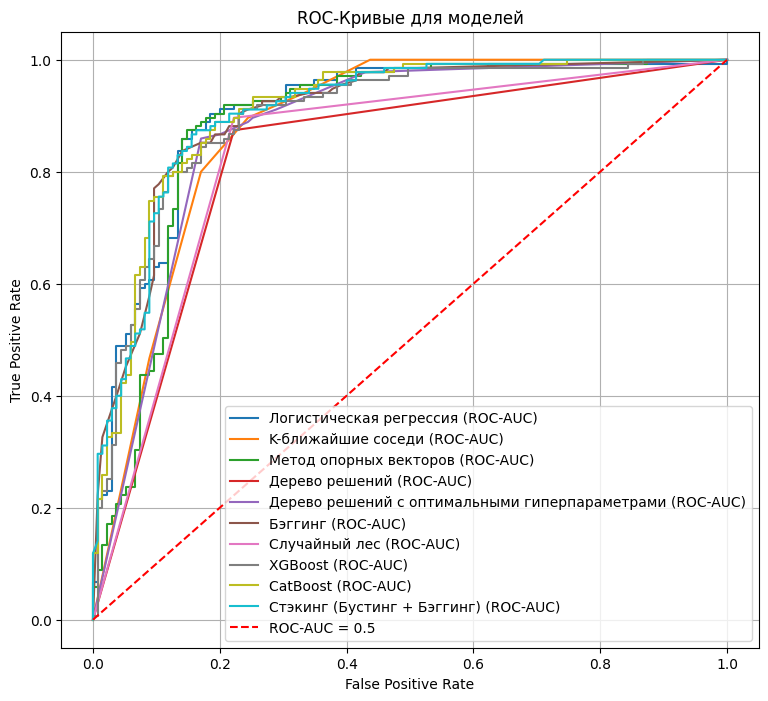

In [48]:

models = {
    "Логистическая регрессия": y_proba_log,
    "K-ближайшие соседи": y_proba_knn,
    "Метод опорных векторов": y_proba_svc,
    "Дерево решений": y_proba_tree,
    "Дерево решений с оптимальными гиперпараметрами": y_proba_best_tree,
    "Бэггинг": y_proba_bagging,
    "Случайный лес": y_proba_rf,
    "XGBoost": y_proba_xgb,
    "CatBoost": y_proba_cat,
    "Стэкинг (Бустинг + Бэггинг)": y_proba_stack,
    }

plt.figure(figsize=(9, 8))
for name, y_proba in models.items():
    # Если y_proba двумерный, берем второй столбец (вероятность класса 1)
    if y_proba.ndim > 1 and y_proba.shape[1] > 1:
        y_scores = y_proba[:, 1]
    # Если y_proba уже одномерный (уже содержит вероятности класса 1)
    else:
        y_scores = y_proba
    precision, recall, _ = precision_recall_curve(y_test, y_scores, pos_label=1)
    fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label=1)
    plt.plot(fpr, tpr, label=f"{name} (ROC-AUC)")
plt.plot(fpr, fpr, c='r', linestyle='--', label=f"ROC-AUC = 0.5")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Кривые для моделей")
plt.legend()
plt.grid(True)
plt.show()

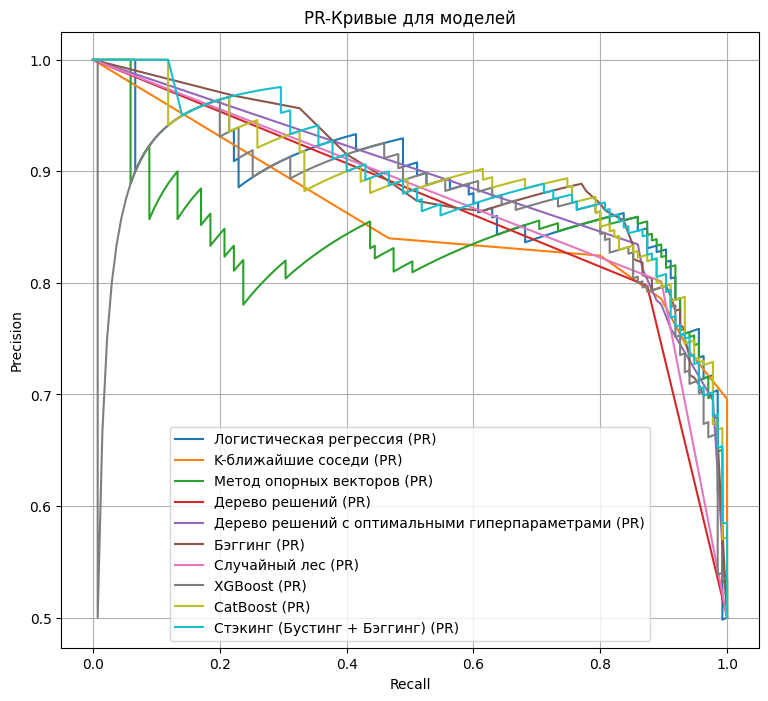

In [50]:
models = {
    "Логистическая регрессия": y_proba_log,
    "K-ближайшие соседи": y_proba_knn,
    "Метод опорных векторов": y_proba_svc,
    "Дерево решений": y_proba_tree,
    "Дерево решений с оптимальными гиперпараметрами": y_proba_best_tree,
    "Бэггинг": y_proba_bagging,
    "Случайный лес": y_proba_rf,
    "XGBoost": y_proba_xgb,
    "CatBoost": y_proba_cat,
    "Стэкинг (Бустинг + Бэггинг)": y_proba_stack,
    }

plt.figure(figsize=(9, 8))
for name, y_proba in models.items():
    # Если y_proba двумерный, берем второй столбец (вероятность класса 1)
    if y_proba.ndim > 1 and y_proba.shape[1] > 1:
        y_scores = y_proba[:, 1]
    # Если y_proba уже одномерный (уже содержит вероятности класса 1)
    else:
        y_scores = y_proba
    precision, recall, _ = precision_recall_curve(y_test, y_scores, pos_label=1)
    plt.plot(recall, precision, label=f"{name} (PR)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-Кривые для моделей")
plt.legend()
plt.grid(True)
plt.show()

# Оптимизация порога классификации



Оптимальный порог для Логистическая регрессия по G-mean: 0.580 с G-mean = 0.859


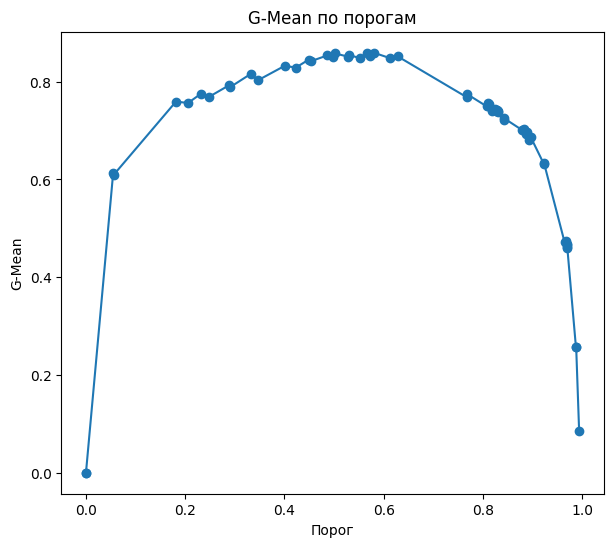



Оптимальный порог для K-ближайшие соседи по G-mean: 0.600 с G-mean = 0.823


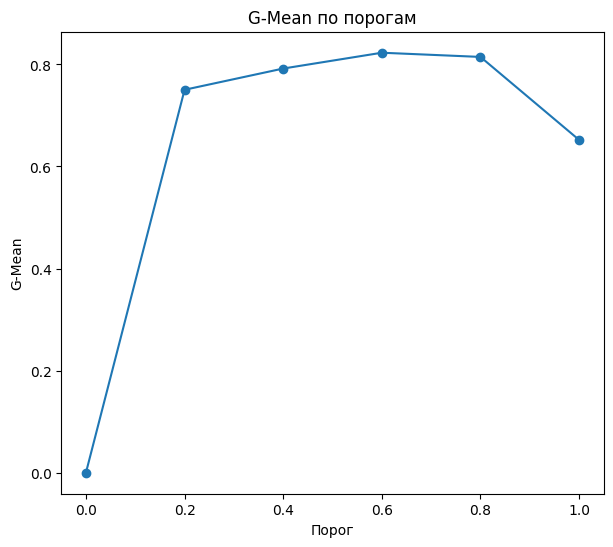



Оптимальный порог для Метод опорных векторов по G-mean: 0.656 с G-mean = 0.863


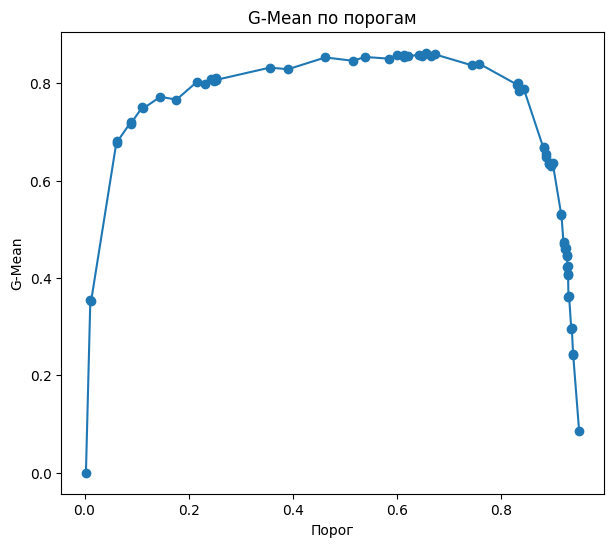



Оптимальный порог для Дерево решений по G-mean: 1.000 с G-mean = 0.825


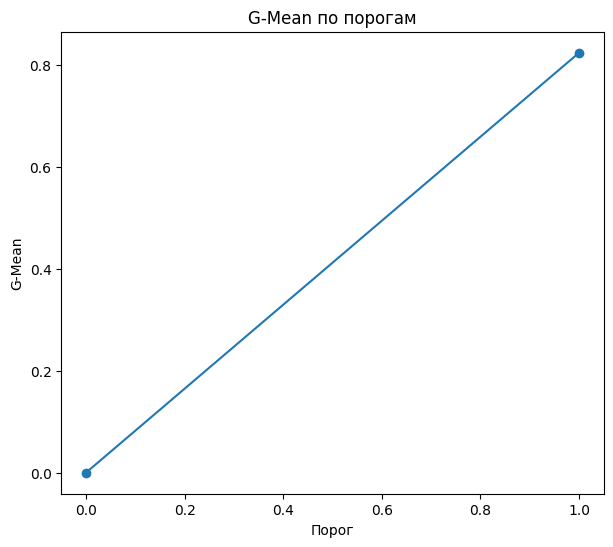



Оптимальный порог для Дерево решений с оптимальными гиперпараметрами по G-mean: 0.894 с G-mean = 0.844


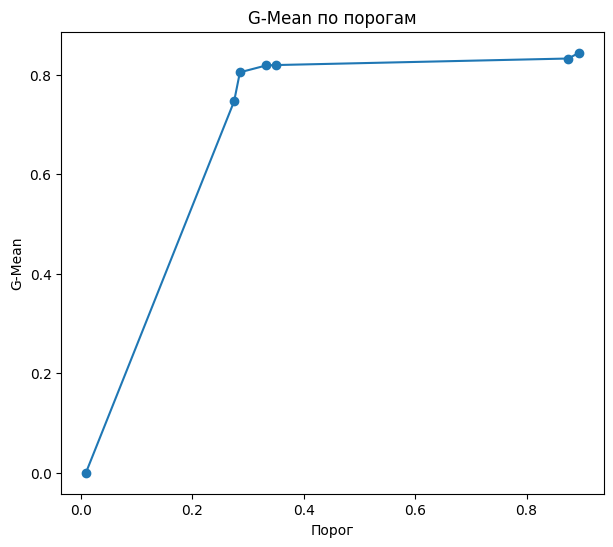



Оптимальный порог для Бэггинг по G-mean: 0.700 с G-mean = 0.848


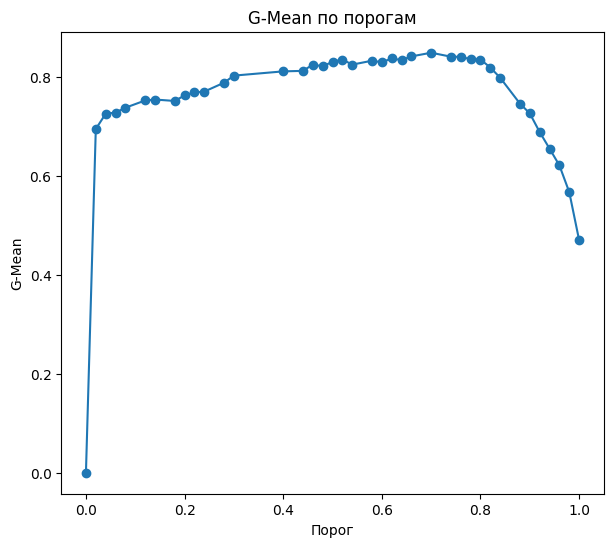



Оптимальный порог для Случайный лес по G-mean: 0.700 с G-mean = 0.848


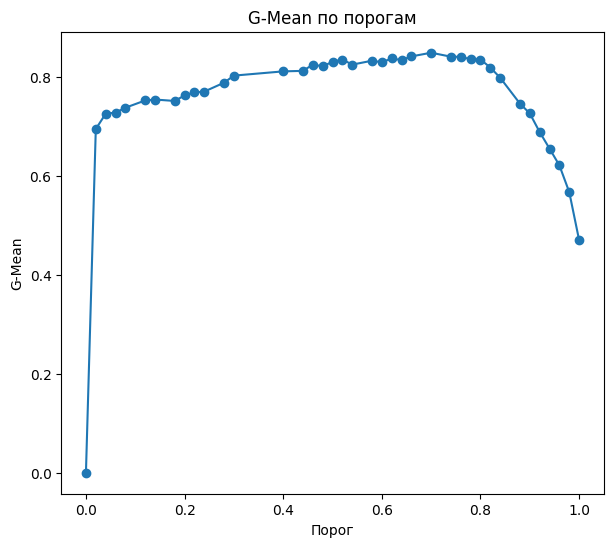



Оптимальный порог для XGBoost по G-mean: 0.794 с G-mean = 0.837


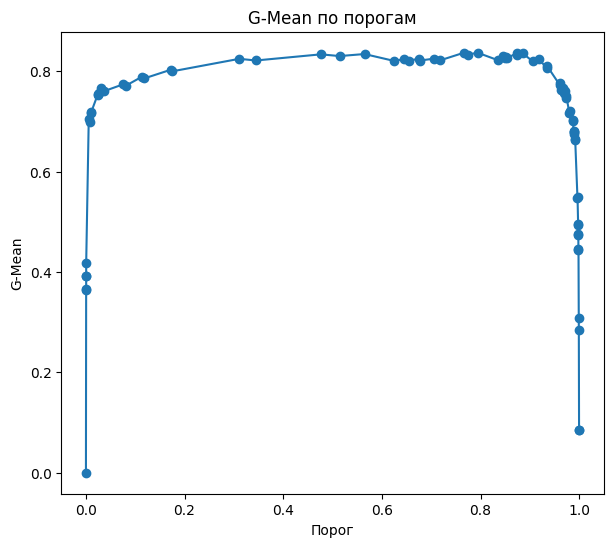



Оптимальный порог для CatBoost по G-mean: 0.581 с G-mean = 0.847


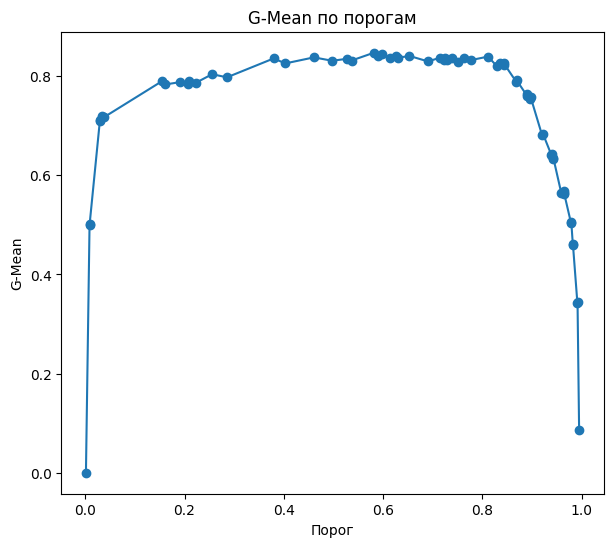



Оптимальный порог для Стэкинг (Бустинг + Бэггинг) по G-mean: 0.676 с G-mean = 0.855


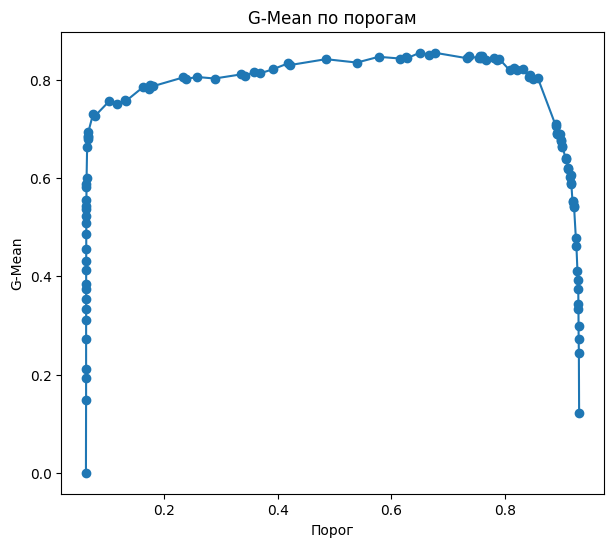

In [53]:
def gmean_score(recall, specificity):
    return np.sqrt(recall * specificity)

models = {
    "Логистическая регрессия": y_proba_log,
    "K-ближайшие соседи": y_proba_knn,
    "Метод опорных векторов": y_proba_svc,
    "Дерево решений": y_proba_tree,
    "Дерево решений с оптимальными гиперпараметрами": y_proba_best_tree,
    "Бэггинг": y_proba_bagging,
    "Случайный лес": y_proba_rf,
    "XGBoost": y_proba_xgb,
    "CatBoost": y_proba_cat,
    "Стэкинг (Бустинг + Бэггинг)": y_proba_stack,
    }


for name, y_proba in models.items():
    # Если y_proba двумерный, берем второй столбец (вероятность класса 1)
    if y_proba.ndim > 1 and y_proba.shape[1] > 1:
        y_scores = y_proba[:, 1]
    # Если y_proba уже одномерный (уже содержит вероятности класса 1)
    plt.figure(figsize=(7, 6))
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    gmeans = [gmean_score(tpr[i], 1 - fpr[i]) for i in range(len(fpr))]
    ix = np.argmax(gmeans)
    print(f"\n\nОптимальный порог для {name} по G-mean: {thresholds[ix]:.3f} с G-mean = {gmeans[ix]:.3f}")

    plt.plot(thresholds, gmeans, marker='o')
    plt.title("G-Mean по порогам")
    plt.xlabel("Порог")
    plt.ylabel("G-Mean")
    plt.show()